(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week12/notebook/demo.ipynb)

# Ensemble Learning

In [1]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np


X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
X.shape

(500, 2)

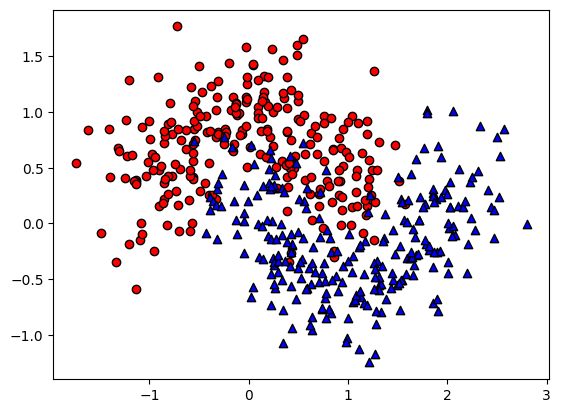

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[y==0,0],X[y==0,1],c='r',marker='o',edgecolors='black')
plt.scatter(X[y==1,0],X[y==1,1],c='b',marker='^',edgecolors='black')
plt.show()

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## Boosting

**Boosting** (originally called hypothesis boosting) refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

### AdaBoost

$$
\begin{aligned}
&\text{Error Rate of Weak Classifier:} \quad
\epsilon_t = \sum_{i=1}^{N} w_i I(y_i \neq h_t(x_i)) \\

&\text{Weight of Weak Classifier:} \quad
\alpha_t = \frac{1}{2} \eta \ln \left(\frac{1 - \epsilon_t}{\epsilon_t} \right) \\

&\text{Final Prediction:} \quad
H(x) = \text{sign} \left\{ \sum_{t=1}^{T} \alpha_t h_t(x) \right\}
\end{aligned}
$$



1
0.5


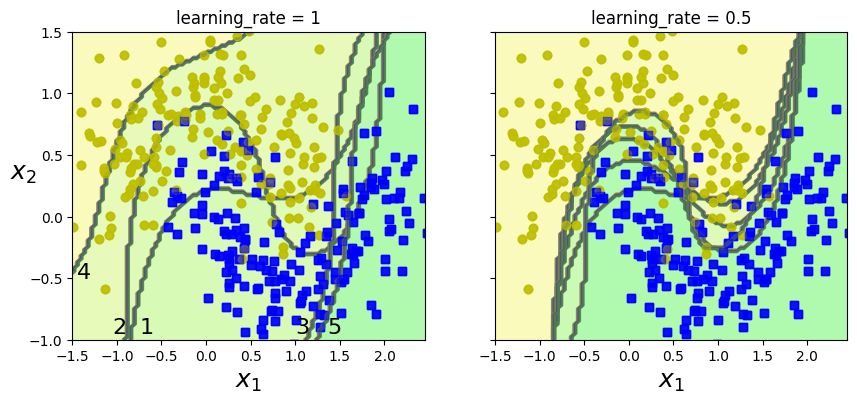

In [5]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    print(learning_rate)
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.896

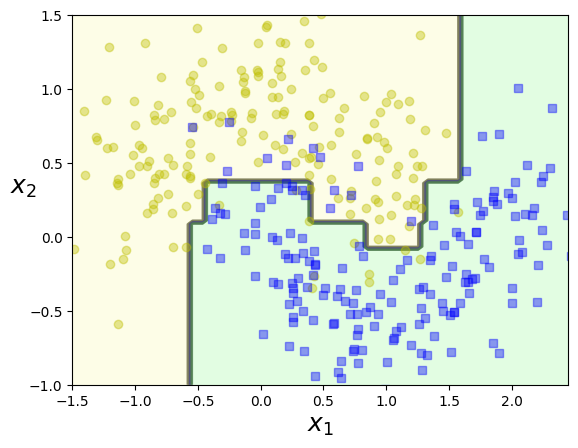

In [7]:
plot_decision_boundary(ada_clf, X_train, y_train, alpha=0.4)

### Gradient Boosting
Just like AdaBoost, gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In case of a gradient boosting regressor, this yields predictions with the following form:
$$
\hat{y}_i = \sum_{k=1}^{n_{iter}} h_m(x_i)
$$

In [8]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [9]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [10]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [11]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [12]:
import matplotlib.pyplot as plt

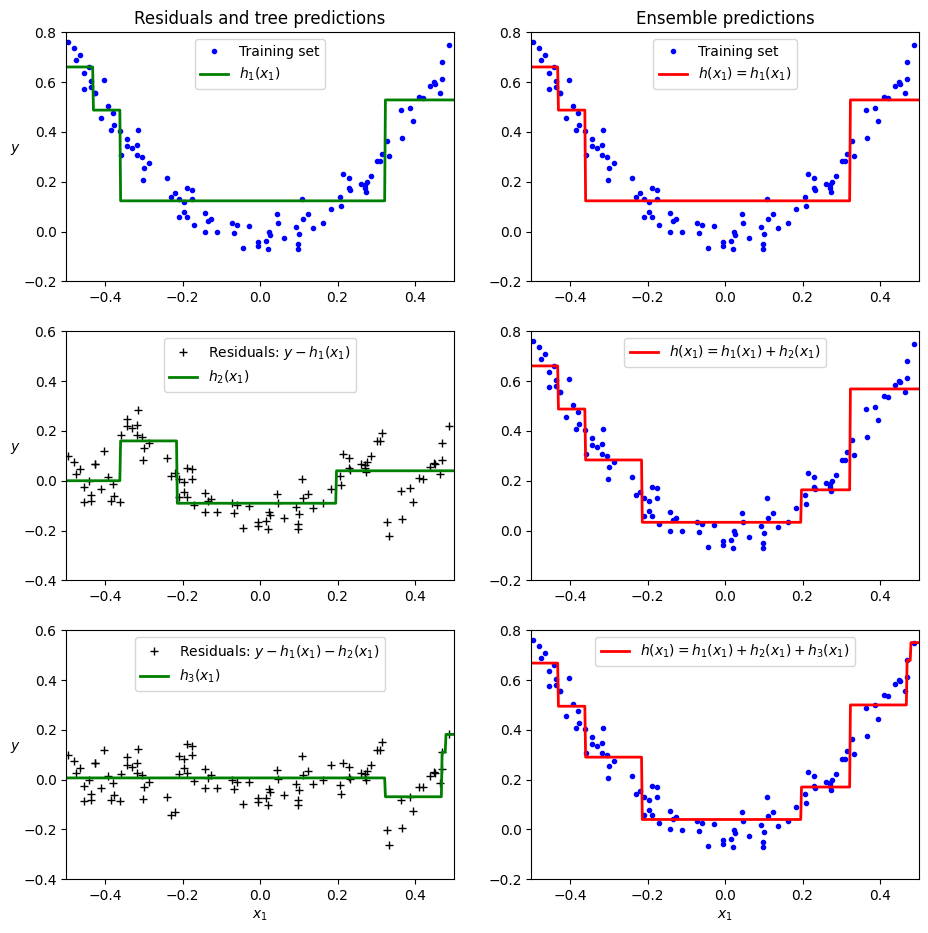

In [13]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")
plt.show()

Directly apply a gradient boosting regressor

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [15]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [16]:
gbrt_best.n_estimators_

92

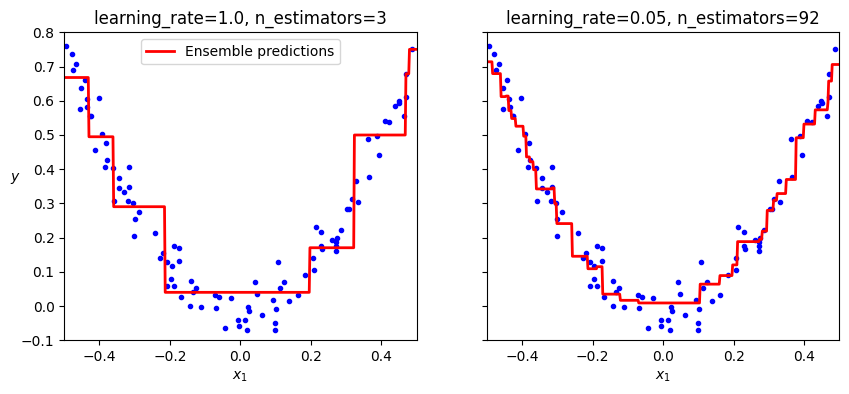

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")
plt.show()

### `XgBoost`

#### Example 1

In [18]:
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) 

In [19]:
from xgboost import XGBRegressor

xgb_reg_50 = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
xgb_reg_50.fit(X, y)

xgb_reg_10 = XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, random_state=42)
xgb_reg_10.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

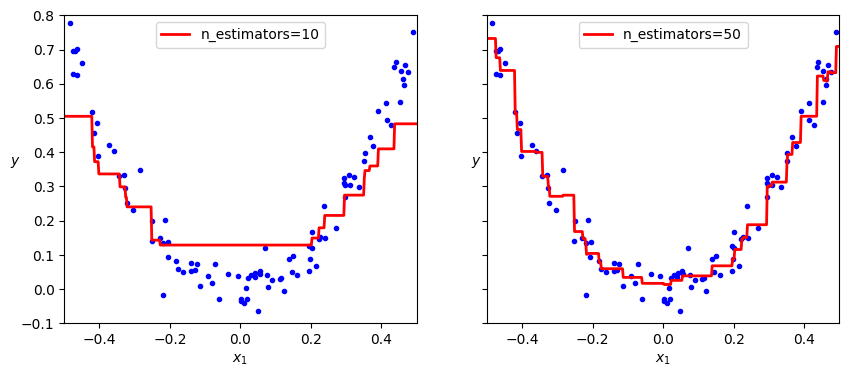

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([xgb_reg_10], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="n_estimators=10")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([xgb_reg_50], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="n_estimators=50")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.show()

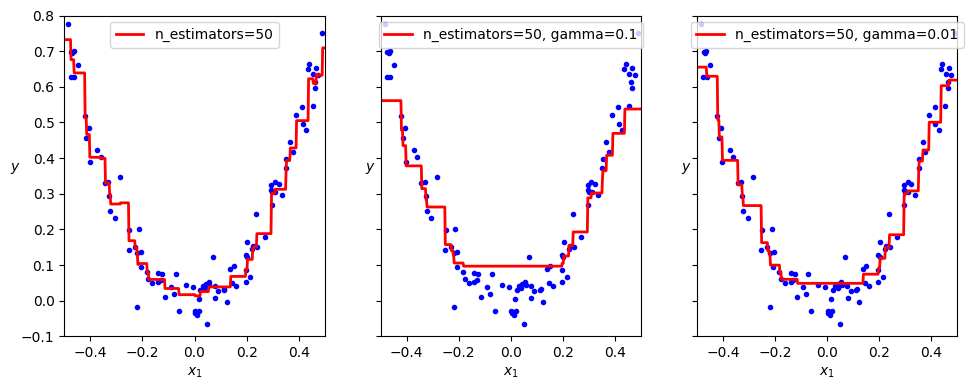

In [21]:
xgb_reg_50 = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
xgb_reg_50.fit(X, y)

xgb_reg_50_v2 = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, gamma=0.1, random_state=42)
xgb_reg_50_v2.fit(X, y)

xgb_reg_50_v3 = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, gamma=0.01, random_state=42)
xgb_reg_50_v3.fit(X, y)

## visulize
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_predictions([xgb_reg_50], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="n_estimators=50")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.sca(axes[1])
plot_predictions([xgb_reg_50_v2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="n_estimators=50, gamma=0.1")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.sca(axes[2])
plot_predictions([xgb_reg_50_v3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="n_estimators=50, gamma=0.01")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

#### Example 2

Accuracy: 0.9561
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



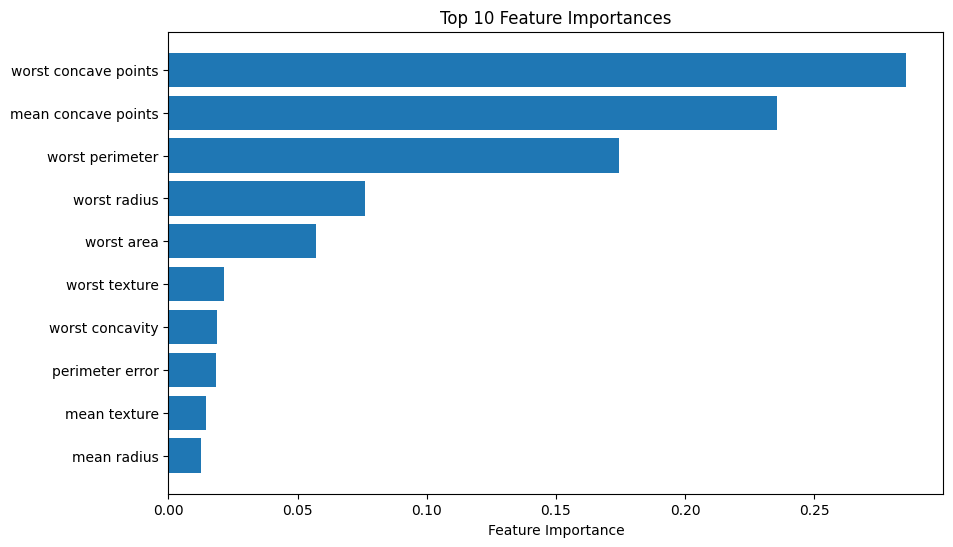

In [22]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names  # Get feature names

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost classifier
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Feature importance visualization
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[sorted_idx], align='center')
plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances")
plt.show()


### LightGBM
- https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4548
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


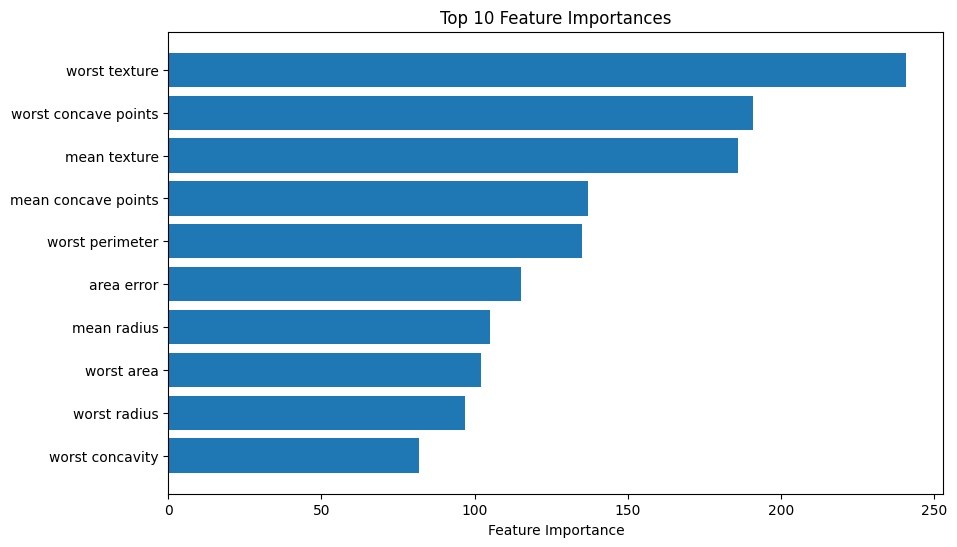

In [23]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names  # Get feature names

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LightGBM classifier
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Feature importance visualization
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[sorted_idx], align='center')
plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances")
plt.show()


## Stacking

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [26]:
stacking_clf.score(X_test,y_test)

0.9736842105263158

In [27]:
from sklearn.metrics import accuracy_score

# Get individual base estimators
base_models = stacking_clf.estimators_
names = [
    'LogisticRegression',
    'RandomForestRegressor',
    'SupportVectorClassifier'
]

# Evaluate each base model
for name, model in zip(names, base_models):
    y_pred = model.predict(X_test)  # Make predictions
    acc = accuracy_score(y_test, y_pred)  # Compute accuracy
    print(f"Accuracy of {name}: {acc:.4f}")

# Evaluate the final stacked model
stacked_acc = accuracy_score(y_test, stacking_clf.predict(X_test))
print(f"Accuracy of StackingClassifier (Final Model): {stacked_acc:.4f}")

Accuracy of LogisticRegression: 0.9649
Accuracy of RandomForestRegressor: 0.9649
Accuracy of SupportVectorClassifier: 0.9474
Accuracy of StackingClassifier (Final Model): 0.9737


# Model Serving

## `Pickle`
Serialize a model for later usage

### Example 1 - Save a Python object to local storage

In [29]:
import pickle

data = {
    'name': 'John Doe',
    'age': 30,
    'city': 'New York',
    'occupation': 'Software Engineer'
}

# Save this dictionary to a file
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

print("Data saved to file data.pickle.")

Data saved to file data.pickle.


In [30]:
# Load the dictionary back from the pickle file
with open('data.pickle', 'rb') as f:
    data2 = pickle.load(f)
print("Dictionary loaded successfully!")

Dictionary loaded successfully!


In [31]:
data2

{'name': 'John Doe',
 'age': 30,
 'city': 'New York',
 'occupation': 'Software Engineer'}

In [32]:
data2 == data

True

In [33]:
id(data2), id(data)

(4863126336, 4842096768)

### Example 2 - Save a ML model

In [34]:
import pickle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset loaded and split successfully!")

Dataset loaded and split successfully!


In [35]:
# Train a RandomForest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


In [36]:
# Save the trained model to a file
with open("iris_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Model saved successfully as 'iris_model.pkl'!")

Model saved successfully as 'iris_model.pkl'!


In [37]:
# Predict with the in-memory model
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 1.0


In [38]:
y_pred[:20]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2])

In [39]:
y_test[:20]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2])

In [40]:
# Predict with the saved model
with open('iris_model.pkl', 'rb') as f:
    model2 = pickle.load(f)

y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)

Accuracy: 1.0


In [41]:
y_pred2[:20]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2])

In [42]:
y_test[:20]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2])